In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt


import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from nltk.corpus import stopwords


In [2]:
df = pd.read_csv(r'C:\Users\Name\Documents\Python Notebook\amazon_bestseller.csv', sep = ',')


In [3]:
df.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


In [4]:
df.nunique()

Name           351
Author         248
User Rating     14
Reviews        346
Price           40
Year            11
Genre            2
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         550 non-null    object 
 1   Author       550 non-null    object 
 2   User Rating  550 non-null    float64
 3   Reviews      550 non-null    int64  
 4   Price        550 non-null    int64  
 5   Year         550 non-null    int64  
 6   Genre        550 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 30.2+ KB


In [6]:
df['User Rating'].describe()

count    550.000000
mean       4.618364
std        0.226980
min        3.300000
25%        4.500000
50%        4.700000
75%        4.800000
max        4.900000
Name: User Rating, dtype: float64

In [7]:
df['Reviews'].describe()

count      550.000000
mean     11953.281818
std      11731.132017
min         37.000000
25%       4058.000000
50%       8580.000000
75%      17253.250000
max      87841.000000
Name: Reviews, dtype: float64

In [8]:
df['Price'].describe()

count    550.000000
mean      13.100000
std       10.842262
min        0.000000
25%        7.000000
50%       11.000000
75%       16.000000
max      105.000000
Name: Price, dtype: float64

In [37]:
def autolabel(rects, labels=None, height_factor=1.05):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if labels is not None:
            try:
                label = labels[i]
            except (TypeError, KeyError):
                label = ' '
        else:
            label = '%d' % int(height)
        ax.text(rect.get_x() + rect.get_width()/2., height_factor*height,
                '{}'.format(label),
                ha='center', va='bottom')

#reference for autolabel https://stackoverflow.com/questions/43443219/seaborn-workaround-for-hue-barplot

Text(0.5, 1.0, 'Distribution of Total Books by Genre per Year')

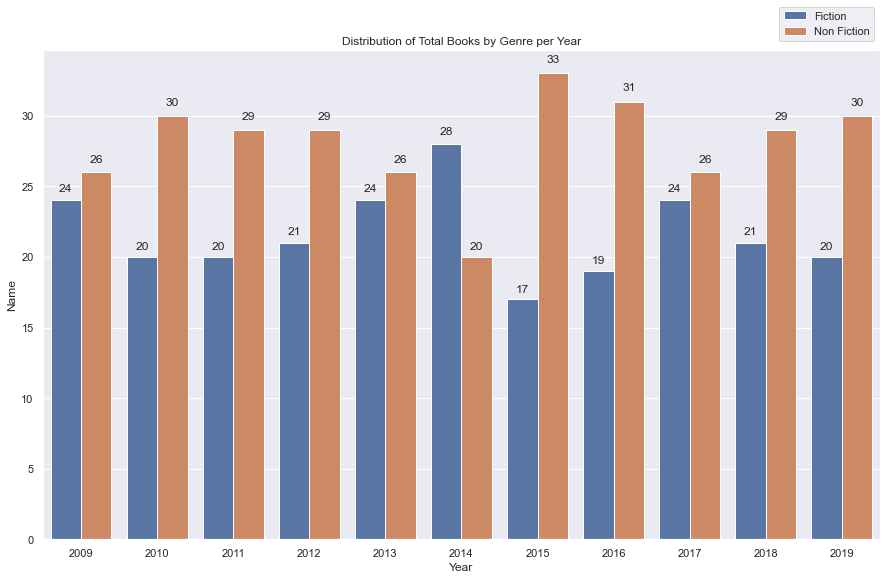

In [35]:
#distribution type books that goes hits by year (fiction / non fiction ) 
df_books = df.groupby(['Genre','Year']).agg({'Name':'nunique'}).reset_index()

ax = sns.barplot(x="Year", y="Name", hue='Genre', data=df_books)
sns.set(rc={'figure.figsize':(15,9)})

autolabel(ax.patches, labels= df_books.Name, height_factor=1.02)
ax.legend(loc=1, bbox_to_anchor=(1.0,1.1))

plt.title('Distribution of Total Books by Genre per Year') # Set the title



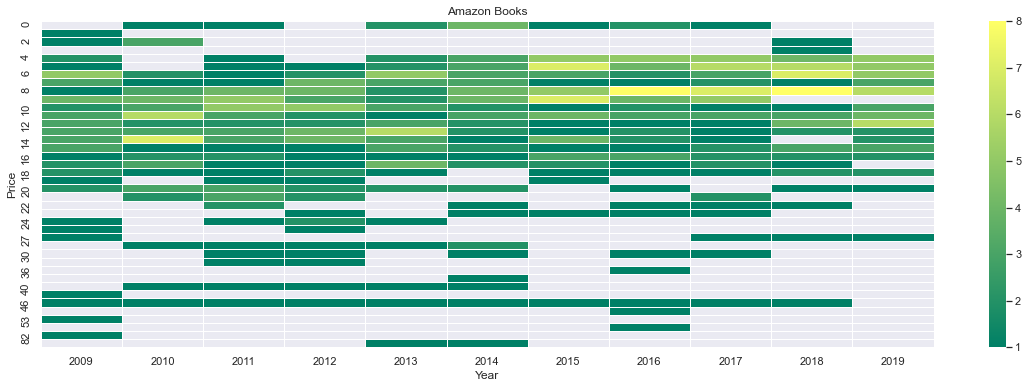

In [13]:
#heatmap price to total book per year
df_price = df.groupby(['Price','Year']).agg({'Name':'nunique'}).reset_index()


plt.figure(figsize=(20, 6)) # Set the size

amazon = df_price.pivot_table( # Pivot Table
    index='Price', # Index
    columns='Year', # Columns
    values='Name' # Value
)

sns.heatmap( # Let's make a heatmap
    amazon, # Data
    cmap='summer', # Color map
    linecolor='white', # Line color
    linewidth=1 # Line width
)

plt.title('Amazon Books') # Set the title
plt.show() # Show 

Text(0.5, 1.0, 'Distribution of Total Price by Genre per Year')

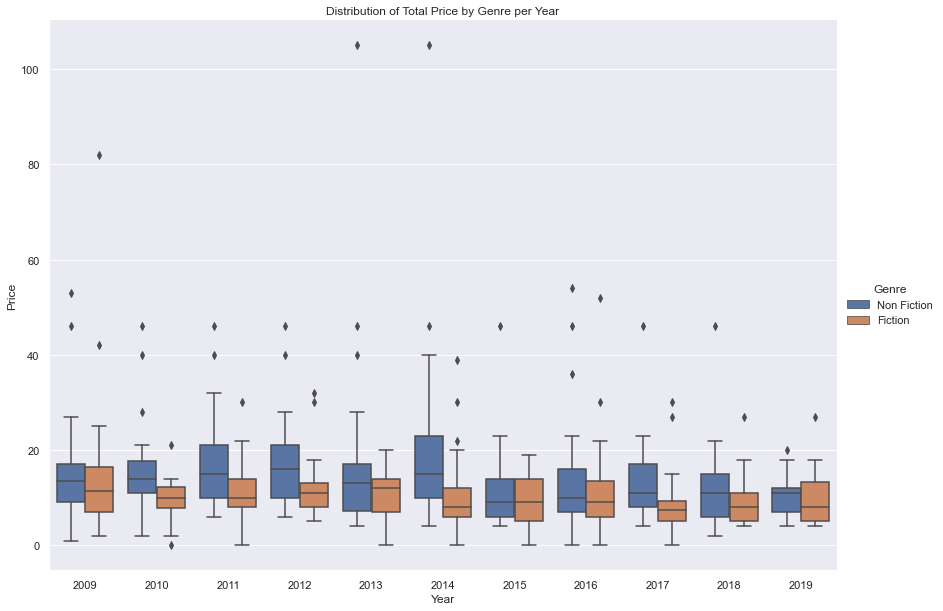

In [14]:
#avg. price along with the year box plot (fiction / non fiction)
ax = sns.catplot(x="Year", y="Price", hue="Genre", kind="box", height=8.27, aspect=11.7/8.27, data=df)

plt.title('Distribution of Total Price by Genre per Year') # Set the title


Text(0.5, 1.0, 'Distribution of Total Rating by Genre per Year')

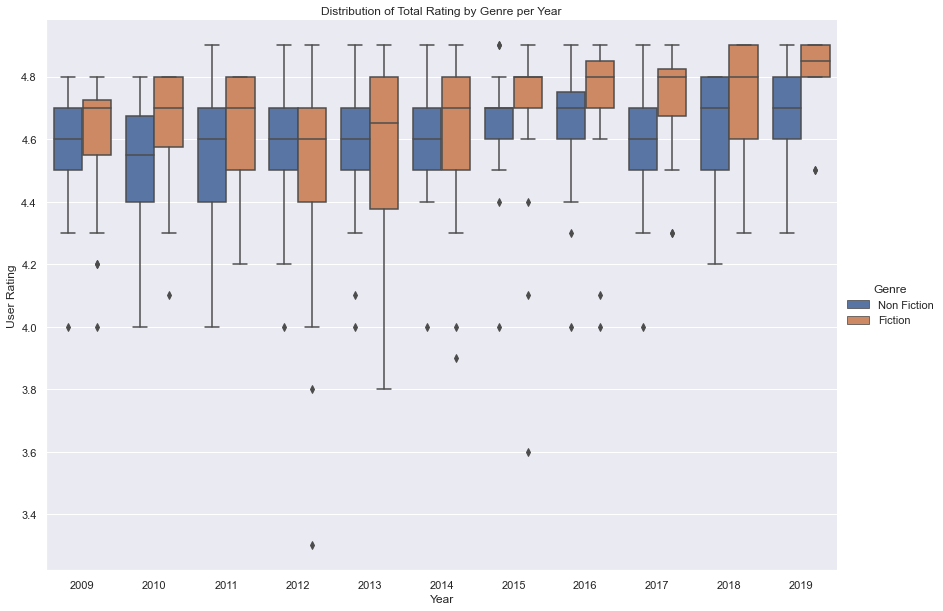

In [15]:
#avg. price along with the year box plot (fiction / non fiction)
ax = sns.catplot(x="Year", y="User Rating", hue="Genre", kind="box", height=8.27, aspect=11.7/8.27, data=df)

plt.title('Distribution of Total Rating by Genre per Year') # Set the title


Text(0.5, 1.0, 'Distribution of Total Reviews by Genre per Year')

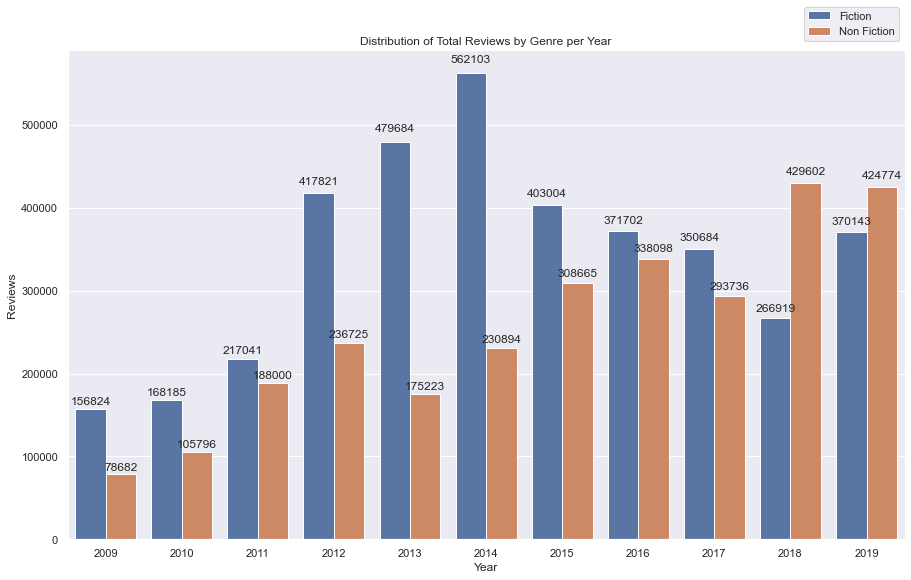

In [36]:
#total review along with the year (fiction / non fiction)

df_review = df.groupby(['Genre','Year']).agg({'Reviews':'sum'}).reset_index()

ax = sns.barplot(x="Year", y="Reviews", hue='Genre', data=df_review)
sns.set(rc={'figure.figsize':(15,9)})

autolabel(ax.patches, labels= df_review.Reviews, height_factor=1.02)
ax.legend(loc=1, bbox_to_anchor=(1.0,1.1))

plt.title('Distribution of Total Reviews by Genre per Year') # Set the title



In [18]:
#top 3 highest author with avg. rating
df_author_rating = df.groupby(['Author','Genre']).agg({'User Rating':'mean'}).reset_index()

df_author_rating['Rank'] = df_author_rating.groupby(['Genre'])['User Rating'].rank(method='dense', ascending=False)

Text(0.5, 1.0, 'Top 3 Dense Rank Author based on Rating on Fiction Genre')

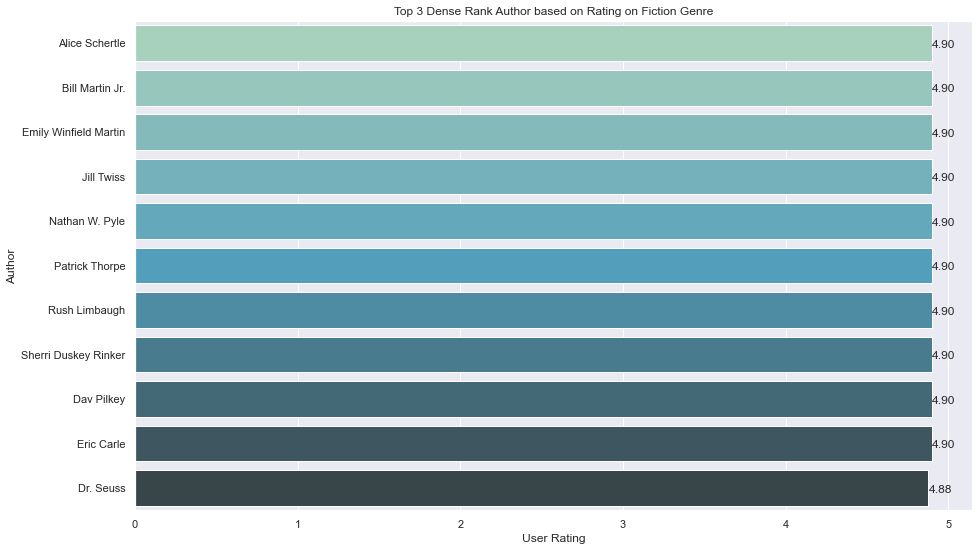

In [31]:
#fiction
df_author_rating_fiction = df_author_rating.loc[(df_author_rating['Rank'] <= 3) & (df_author_rating['Genre'] == 'Fiction')].sort_values('Rank', ascending=True)

ax = sns.barplot(y="Author",x="User Rating", data=df_author_rating_fiction, palette="GnBu_d")

initialx=0
for p in ax.patches:
    ax.text(p.get_width(),initialx+p.get_height()/8,"{:0.2f}".format(p.get_width()))
    initialx+=1
    
sns.set(rc={'figure.figsize':(8,7)})

plt.title('Top 3 Dense Rank Author based on Rating on Fiction Genre') # Set the title

Text(0.5, 1.0, 'Top 3 Dense Rank Author based on Rating on Non Fiction Genre')

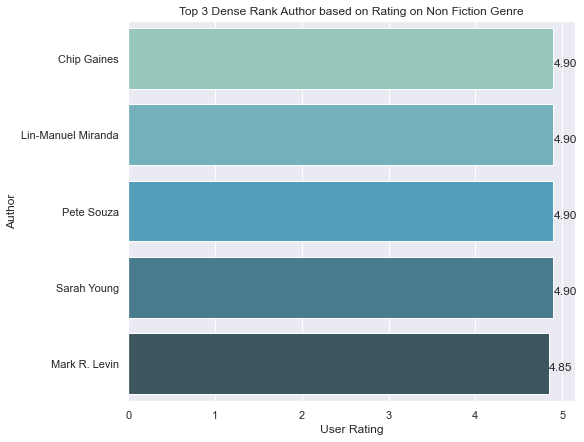

In [20]:
#non fiction
df_author_rating_non_fiction = df_author_rating.loc[(df_author_rating['Rank'] <= 3) & (df_author_rating['Genre'] == 'Non Fiction')].sort_values('Rank', ascending=True)

ax = sns.barplot(y="Author",x="User Rating", data=df_author_rating_non_fiction, palette="GnBu_d")

initialx=0
for p in ax.patches:
    ax.text(p.get_width(),initialx+p.get_height()/8,"{:0.2f}".format(p.get_width()))
    initialx+=1
    
sns.set(rc={'figure.figsize':(7,7)})

plt.title('Top 3 Dense Rank Author based on Rating on Non Fiction Genre') # Set the title

In [21]:
#top 5 author with highest review- fiction/non fiction
df_author_review = df.groupby(['Author','Genre']).agg({'Reviews':'sum'}).reset_index()

df_author_review['Rank'] = df_author_review.groupby(['Genre'])['Reviews'].rank(method='dense', ascending=False)

Text(0.5, 1.0, 'Top 3 Dense Rank Author based on Total Review on Fiction Genre')

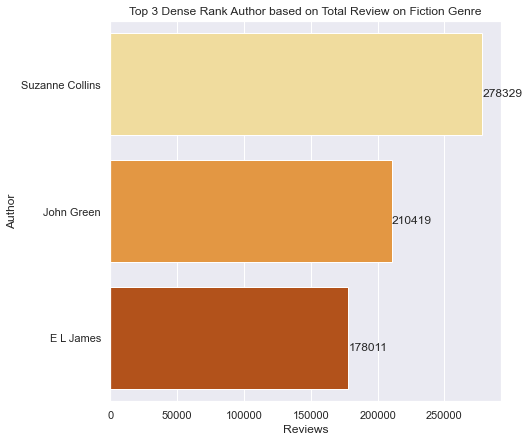

In [22]:
#fiction
df_author_review_fiction = df_author_review.loc[(df_author_review['Rank'] <= 3) & (df_author_review['Genre'] == 'Fiction')].sort_values('Reviews', ascending=False)

ax = sns.barplot(y="Author",x="Reviews", data=df_author_review_fiction, palette="YlOrBr")

initialx=0
for p in ax.patches:
    ax.text(p.get_width(),initialx+p.get_height()/8,"{:1.0f}".format(p.get_width()))
    initialx+=1
    
sns.set(rc={'figure.figsize':(6,5)})

plt.title('Top 3 Dense Rank Author based on Total Review on Fiction Genre') # Set the title

Text(0.5, 1.0, 'Top 3 Dense Rank Author based on Total Review on Non Fiction Genre')

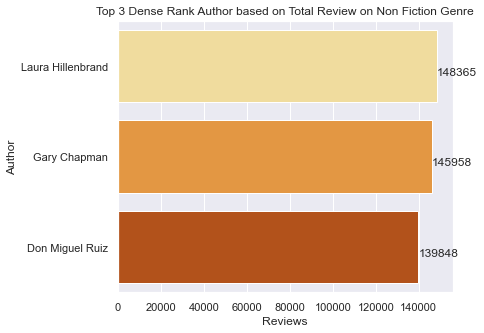

In [23]:
#non fiction
df_author_review_non_fiction = df_author_review.loc[(df_author_review['Rank'] <= 3) & (df_author_review['Genre'] == 'Non Fiction')].sort_values('Reviews', ascending=False)

ax = sns.barplot(y="Author",x="Reviews", data=df_author_review_non_fiction, palette="YlOrBr")

initialx=0
for p in ax.patches:
    ax.text(p.get_width(),initialx+p.get_height()/8,"{:1.0f}".format(p.get_width()))
    initialx+=1
    
sns.set(rc={'figure.figsize':(6,5)})

plt.title('Top 3 Dense Rank Author based on Total Review on Non Fiction Genre') # Set the title

In [24]:
#top 5 highest review book- fiction/non fiction
df_book_review = df.groupby(['Name', 'Genre']).agg({'Reviews':'sum'}).reset_index()

df_book_review['Rank'] = df_book_review.groupby(['Genre'])['Reviews'].rank(method='dense', ascending=False)

Text(0.5, 1.0, 'Top 5 Dense Rank Book based on Total Review on Fiction Genre')

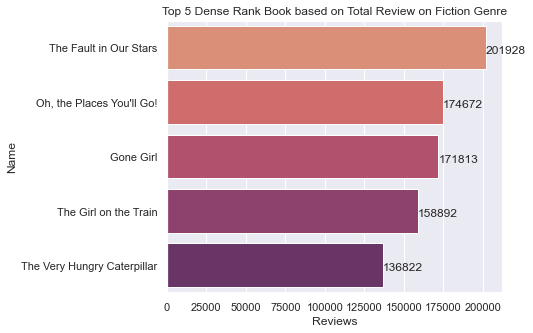

In [25]:
#fiction
df_book_review_fiction = df_book_review.loc[(df_book_review['Rank'] <= 5) & (df_book_review['Genre'] == 'Fiction')].sort_values('Reviews', ascending=False)

ax = sns.barplot(y="Name",x="Reviews", data=df_book_review_fiction, palette="flare")

initialx=0
for p in ax.patches:
    ax.text(p.get_width(),initialx+p.get_height()/8,"{:1.0f}".format(p.get_width()))
    initialx+=1
    
sns.set(rc={'figure.figsize':(6,5)})

plt.title('Top 5 Dense Rank Book based on Total Review on Fiction Genre') # Set the title

Text(0.5, 1.0, 'Top 5 Dense Rank Book based on Total Review on Non Fiction Genre')

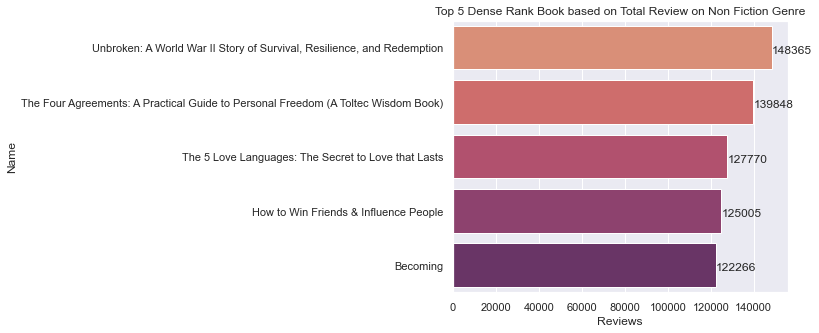

In [26]:
#non fiction
df_book_review_non_fiction = df_book_review.loc[(df_book_review['Rank'] <= 5) & (df_book_review['Genre'] == 'Non Fiction')].sort_values('Reviews', ascending=False)

ax = sns.barplot(y="Name",x="Reviews", data=df_book_review_non_fiction, palette="flare")

initialx=0
for p in ax.patches:
    ax.text(p.get_width(),initialx+p.get_height()/8,"{:1.0f}".format(p.get_width()))
    initialx+=1
    
sns.set(rc={'figure.figsize':(6,5)})

plt.title('Top 5 Dense Rank Book based on Total Review on Non Fiction Genre') # Set the title

Wordcloud

In [39]:
#word cloud book name
df['Name'] = df['Name'].str.strip().str.lower().str.replace('[^A-Za-z0-9]+',' ', regex=True)

In [40]:
newStopwords = stopwords.words('english')

In [41]:
df['new_name'] = df['Name'].apply(lambda x: ' '.join([word for word in x.split() if word not in (newStopwords)]))

In [42]:
def remDeps(s):
    return {" ".join(sorted(key.split(" "))):s[key] for key in s}

In [43]:
ngram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=3)

# X matrix where the row represents sentences and column is our one-hot vector for each token in our vocabulary
X = ngram_vectorizer.fit_transform(df['new_name'])

# Vocabulary
vocab = list(ngram_vectorizer.get_feature_names())

# Column-wise sum of the X matrix.
# It's some crazy numpy syntax that looks horribly unpythonic
# For details, see http://stackoverflow.com/questions/3337301/numpy-matrix-to-array
# and http://stackoverflow.com/questions/13567345/how-to-calculate-the-sum-of-all-columns-of-a-2d-numpy-array-efficiently
counts = X.sum(axis=0).A1
freq_distribution = Counter(dict(zip(vocab, counts)))


##for i in freq_distribution.most_common(20):
##    print(i)

# Counter to Data Frame (20 Most Common Words)
rslt = pd.DataFrame(freq_distribution.most_common(100),
                  columns=['Word', 'Frequency'])

rslt['Word'] = rslt['Word'].apply(lambda x: ' '.join(sorted(x.split(' '))))

rslt = rslt.groupby('Word').sum().reset_index()



print(rslt)

        Word  Frequency
0         10          6
1        100          6
2        6th         10
3      adult          7
4   american         16
..       ...        ...
95       war          8
96    weight          9
97     wimpy         11
98    wisdom          7
99     world         14

[100 rows x 2 columns]


In [44]:
tuples = tuple([tuple(x) for x in rslt.Word.value_counts().reset_index().values])

##https://stackoverflow.com/questions/38465478/wordcloud-from-data-frame-with-frequency-python
##https://stackoverflow.com/questions/39615520/pandas-create-word-cloud-from-a-column-with-strings

In [45]:
def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(203,100%%, %50d%%)" % np.random.randint(70,80))

##pick color hsl https://hslpicker.com/#009dff

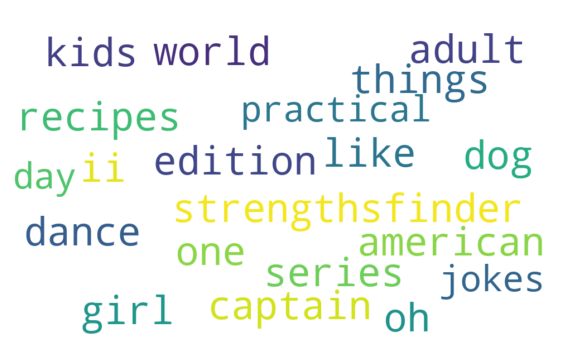

In [54]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=70, max_words=20, width=1000, height=600, background_color="white").generate_from_frequencies(dict(tuples))
#wordcloud.recolor(color_func = grey_color_func)
plt.figure(figsize=(10,10))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()